In [1]:
%run ../scripts/setup.ipynb
%run ../scripts/text_data_preprocessing_steps.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!



# PR 2_42


The aim of our research is to analyze a set of scientific papers about the


medical imaging techniques for COVID-19.

We obtained our data from the references of the article "Medical imaging and computational 


image analysis in COVID-19 diagnosis: A review" (__[link to the paper](https://www.sciencedirect.com/science/article/pii/S0010482521003991)__ )


written by Shahabedin Nabavi, Azar Ejmalian, Mohsen Ebrahimi Moghaddam, Ahmad Ali Abin, 

Alejandro F. Frangi, Mohammad Mohammadi and Hamidreza Saligheh Rad. 

Then we stored in a CSV file.


In [2]:
# Upload the data
data = pd.read_csv(f'{DATA_PATH}/Cartel1.csv', sep = ";")
data.head()

Title  \
0       WHO coronavirus disease (COVID-19) dashboard   
1  WHO. Coronavirus disease (COVID-19) advice for...   
2  COVID-19 patients and the radiology department...   
3  An update on COVID-19 for the radiologist-A Br...   
4  A British Society of Thoracic Imaging statemen...   

                                            abstract modality method  
0  The 2019-2020 global pandemic has been caused ...      NaN    NaN  
1  Coronavirus disease (COVID-19) is an infectiou...      NaN    NaN  
2  This document from the European Society of Rad...      NaN    NaN  
3  In December 2019, Wuhan City (Hubei Province, ...      NaN    NaN  
4  In accordance with guidance from the Chief Med...      NaN    NaN

In [3]:
data.shape

(282, 4)

In [4]:
data.dtypes

Title       object
abstract    object
modality    object
method      object
dtype: object

## Research questions

* After preprocessing data, which are the most common monogram and n-gram?
* Which are the main topics in the papers?
* What is the general sentiment of our texts?
* Which are the most similar papers in our dataset?
* How can they be grouped together using clustering techniques? And which are the key features?
* How can we predict the unknown modalities and methods? 


In [5]:
import re, nltk, spacy, string
from pprint import pprint

In [6]:
abstract = data['abstract']

### Preprocessing 

In [7]:
# remove the punctuation
def text_clean(corpus):
    cleaned_corpus = pd.Series(dtype='object')
    for row in corpus:
        qs = []
        for word in row.split():
            p1 = re.sub(pattern='[^a-zA-Z0-9]',repl=' ',string=word)
            qs.append(p1)
        cleaned_corpus = pd.concat([cleaned_corpus, pd.Series(' '.join(qs))])
    return cleaned_corpus

nopar = text_clean(abstract)

In [8]:
def preprocess_list(corpus, keep_list, cleaning = True, stemming = False, stem_type = None, lemmatization = False, remove_stopwords = True):
    
    if cleaning == True:
        corpus = text_clean_list(corpus, keep_list)
    
    if remove_stopwords == True:
        corpus = stopwords_removal(corpus)
    else :
        corpus = [[x for x in x.split()] for x in corpus]
    
    if lemmatization == True:
        corpus = lemmatize(corpus)
        
        
    if stemming == True:
        corpus = stem(corpus, stem_type)
    
    corpus = [' '.join(x) for x in corpus]        

    return corpus

In [9]:
def lemmatize(corpus):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(x, pos = 'v') for x in x] for x in corpus]
    return corpus

In [10]:
def stopwords_removal(corpus):
    hw_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
    stop = set(stopwords.words('english'))
    for word in hw_words:
        stop.remove(word)
    corpus = [[x for x in x.split() if x not in stop] for x in corpus]
    return corpus

In [11]:
# list of words to keep upper case
keep = [ "FDG", "CNN","PET", "PCR", "CT", "RT", "CI", "X","Ray", "CXR", "Wuhan", "China","Hubei"]

clean = preprocess_list(nopar , keep, cleaning = True, lemmatization = True, remove_stopwords = True)
dfclean = pd.DataFrame(clean)
dfclean.rename(columns={0: "abstract"}, inplace=True)

In [12]:
from nltk.tokenize import word_tokenize

# remove these words from the dataset
remove_list = ["2019", "coronavirus", "covid", "19", "2020", "corona", "cov", "sars", "wuhan", "china"]
dfclean['abstract'] = dfclean['abstract'].apply(lambda x: ' '.join([word for word in  word_tokenize(x)  if word.lower() not in remove_list]))
dfclean

abstract
0    global pandemic cause disease call disease dis...
1    disease infectious disease cause newly discove...
2    document european society radiology esr europe...
3    december city Hubei province report febrile re...
4    accordance guidance chief medical officer offi...
..                                                 ...
277  disease become one urgent public health events...
278  novel first appear province spread quickly aro...
279  understand classify chest X Ray CXR computeris...
280  work introduce fourier bessel series expansion...
281  virus disease announce pandemic spread rapidly...

[282 rows x 1 columns]

In [13]:
def replace(text, old_word, new_word):
    words = text.split()
    new_text = ' '.join([new_word if word == old_word else word for word in words])
    return new_text

dfclean['abstract'] = dfclean['abstract'].apply(lambda x: replace(x, "opacities", "opacity"))

## Frequent ngrams and wordclouds

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    # we select bigram, trigram and tetragram
    vec = CountVectorizer(ngram_range=(2, 4), stop_words='english', lowercase=False).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words1 = get_top_n_bigram(dfclean['abstract'], 100)
ngram = pd.DataFrame(common_words1, columns = ['n-gram' , 'count'])
ngram.head(20)

n-gram  count
0                    chest CT    298
1                 grind glass    206
2               glass opacity    175
3         grind glass opacity    174
4                      RT PCR    169
5                    CT image    156
6                     CT scan    150
7                  deep learn     73
8              chain reaction     69
9                   chest ray     69
10           polymerase chain     67
11  polymerase chain reaction     67
12          acute respiratory     66
13                 CT feature     65
14         compute tomography     63
15       respiratory syndrome     60
16              tomography CT     60
17             chest CT image     57
18      compute tomography CT     56
19             neural network     56

In [15]:
# we create a list of our ngrams
ngramtext = []
for i in range(len(ngram)):
    ngramtext.append(str(ngram.iloc[i]["n-gram"]))

# then we remove the bigrams that compose a frequent trigram
remove = ["grind glass", "reaction RT", "reaction RT PCR", "polymerase chain", "RT PCR test", 
          "severe acute", 'acute respiratory syndrome', "glass opacity", 'transcription polymerase',
          "grind glass opacities", 'convolutional neural', 'interlobular septal']
ngramtext2 = [x for x in ngramtext if x not in remove]

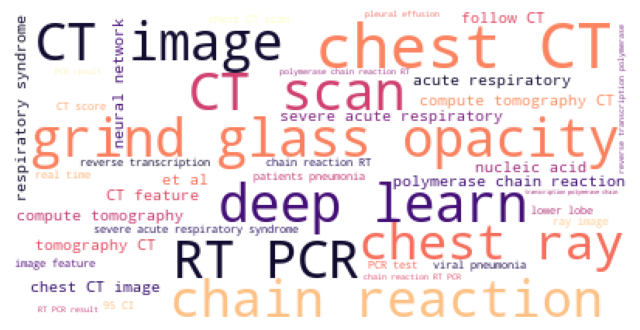

In [16]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(8.0,8.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud( background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, random_state=42,
                        colormap='magma'
                        ).generate_from_frequencies({n_gram:1 for n_gram in ngramtext2})
fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

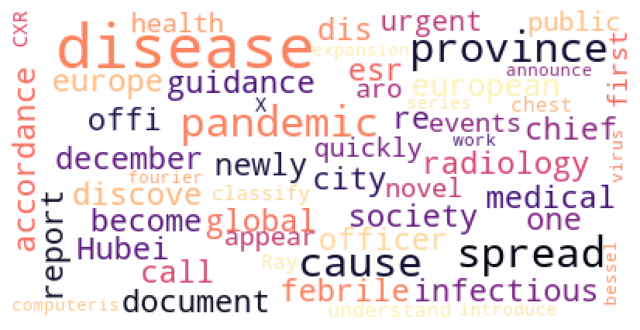

In [17]:
mpl.rcParams['figure.figsize']=(8.0,8.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud( background_color='white', stopwords=stopwords, max_words=55, max_font_size=40, random_state=42,
                          colormap='magma'
                         ).generate(str(dfclean["abstract"]))

fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
import re, nltk, spacy, string
from pprint import pprint

## Topic Modelling

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                        # minimum required occurences of a word 
                             stop_words='english',             
                             lowercase=False,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,              
                             ngram_range=(2, 2)             # we select only bigrams
                            )
data_vectorized = vectorizer.fit_transform(dfclean['abstract'])

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=4, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
lda_model.components_

array([[0.85918398, 1.10567374, 0.28238183, ..., 3.34631996, 0.2703052 ,
        0.31197609],
       [1.42306371, 2.99740031, 1.66277234, ..., 0.3956066 , 1.65713425,
        3.01336933],
       [0.8805151 , 0.96694513, 0.27292025, ..., 1.09121893, 0.85903782,
        0.2661713 ],
       [0.68105744, 0.29790123, 4.01858615, ..., 0.27593593, 0.27909579,
        0.28357735]])

In [21]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


In [22]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

Word 0             Word 1        Word 2  \
Topic 0              grind glass      glass opacity  nucleic acid   
Topic 1  sensitivity specificity  chest radiographs    deep learn   
Topic 2                  FDG PET      machine learn       18f FDG   
Topic 3               deep learn     neural network     chest ray   

                         Word 3              Word 4                Word 5  \
Topic 0       acute respiratory  compute tomography        chain reaction   
Topic 1  operate characteristic    receiver operate  characteristic curve   
Topic 2        lung involvement        suspect case            FDG uptake   
Topic 3             learn model           ray image             CXR image   

                Word 6                Word 7                Word 8  \
Topic 0    chest image      polymerase chain  respiratory syndrome   
Topic 1  area receiver              test set           chest image   
Topic 2    period time   diagnosis infection          study report   
Topic 3      pre train  convolutional neural         propose model   

                Word 9           Word 10                   Word 11  \
Topic 0      real time      severe acute                lower lobe   
Topic 1     chest scan    neural network  transcription polymerase   
Topic 2     lymph node         chest ray          pleural effusion   
Topic 3  model achieve  achieve accuracy   artificial intelligence   

                       Word 12           Word 13         Word 14  \
Topic 0          image feature    septal thicken      crazy pave   
Topic 1  reverse transcription  polymerase chain  chain reaction   
Topic 2      feature extractor  suspect patients    short period   
Topic 3         propose method   novel pneumonia   medical image   

                         Word 15          Word 16             Word 17  \
Topic 0        ggo consolidation         PCR test  patients pneumonia   
Topic 1  artificial intelligence         PCR test            mean age   
Topic 2            patients lung  patients normal     viral pneumonia   
Topic 3              network CNN     propose deep           fine tune   

                     Word 18           Word 19  
Topic 0     january february  reactive protein  
Topic 1      pneumonia chest         age years  
Topic 2       highly suspect      normal chest  
Topic 3  bacterial pneumonia        method use

In [23]:
# Topic interpretations
Topics_theme = ['Ground-glass opacity/ Acute Respiratory Syndrome', 'Radiography/Pneumonia/AI', 
                'PET 18F-FDG', 'Machine learning techniques/Chest X-Ray']
df_topic_keywords['topic_theme'] = Topics_theme

The topics identified by the analysis are purely technical and related to the techniques discussed in the papers.

* Ground-glass opacity is a term used in medicine to describe an anomaly seen in lung imaging. It refers to an area of the lung that appears opaque but still translucent, like ground glass, when viewed through X-ray or CT scan.
* PET 18F-FDG  is a medical imaging procedure where a radiopharmaceutical called 18F-fluorodeoxyglucose (18F-FDG) is injected into the body. PET allows visualization and assessment of metabolic activity in tissues of the body, aiding doctors in detecting areas of interest such as tumors or inflamed areas

In [24]:
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

topic_theme Ground-glass opacity/ Acute Respiratory Syndrome  \
Word 0                                           grind glass   
Word 1                                         glass opacity   
Word 2                                          nucleic acid   
Word 3                                     acute respiratory   
Word 4                                    compute tomography   
Word 5                                        chain reaction   
Word 6                                           chest image   
Word 7                                      polymerase chain   
Word 8                                  respiratory syndrome   
Word 9                                             real time   
Word 10                                         severe acute   
Word 11                                           lower lobe   
Word 12                                        image feature   
Word 13                                       septal thicken   
Word 14                                           crazy pave   
Word 15                                    ggo consolidation   
Word 16                                             PCR test   
Word 17                                   patients pneumonia   
Word 18                                     january february   
Word 19                                     reactive protein   

topic_theme  Radiography/Pneumonia/AI          PET 18F-FDG  \
Word 0        sensitivity specificity              FDG PET   
Word 1              chest radiographs        machine learn   
Word 2                     deep learn              18f FDG   
Word 3         operate characteristic     lung involvement   
Word 4               receiver operate         suspect case   
Word 5           characteristic curve           FDG uptake   
Word 6                  area receiver          period time   
Word 7                       test set  diagnosis infection   
Word 8                    chest image         study report   
Word 9                     chest scan           lymph node   
Word 10                neural network            chest ray   
Word 11      transcription polymerase     pleural effusion   
Word 12         reverse transcription    feature extractor   
Word 13              polymerase chain     suspect patients   
Word 14                chain reaction         short period   
Word 15       artificial intelligence        patients lung   
Word 16                      PCR test      patients normal   
Word 17                      mean age      viral pneumonia   
Word 18               pneumonia chest       highly suspect   
Word 19                     age years         normal chest   

topic_theme Machine learning techniques/Chest X-Ray  
Word 0                                   deep learn  
Word 1                               neural network  
Word 2                                    chest ray  
Word 3                                  learn model  
Word 4                                    ray image  
Word 5                                    CXR image  
Word 6                                    pre train  
Word 7                         convolutional neural  
Word 8                                propose model  
Word 9                                model achieve  
Word 10                            achieve accuracy  
Word 11                     artificial intelligence  
Word 12                              propose method  
Word 13                             novel pneumonia  
Word 14                               medical image  
Word 15                                 network CNN  
Word 16                                propose deep  
Word 17                                   fine tune  
Word 18                         bacterial pneumonia  
Word 19                                  method use

In [25]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)
topicnames = df_topic_keywords.T.columns
docnames = ["Doc" + str(i) for i in range(len(dfclean))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [26]:
df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(data["Title"], df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)
df_sent_topic

Title  \
0         WHO coronavirus disease (COVID-19) dashboard   
1    WHO. Coronavirus disease (COVID-19) advice for...   
2    COVID-19 patients and the radiology department...   
3    An update on COVID-19 for the radiologist-A Br...   
4    A British Society of Thoracic Imaging statemen...   
..                                                 ...   
277  D2A U-net: automatic segmentation of COVID-19 ...   
278  Diagnosing COVID-19 pneumonia from x-ray and C...   
279  Classification of COVID-19 chest X-Ray and CT ...   
280  FBSED based automatic diagnosis of COVID-19 us...   
281  Deep-chest: multi-classification deep learning...   

     Ground-glass opacity/ Acute Respiratory Syndrome  \
0                                                0.29   
1                                                0.01   
2                                                0.92   
3                                                0.98   
4                                                0.78   
..                                                ...   
277                                              0.01   
278                                              0.01   
279                                              0.01   
280                                              0.01   
281                                              0.01   

     Radiography/Pneumonia/AI  PET 18F-FDG  \
0                        0.02         0.02   
1                        0.01         0.01   
2                        0.03         0.03   
3                        0.01         0.01   
4                        0.20         0.01   
..                        ...          ...   
277                      0.01         0.01   
278                      0.56         0.01   
279                      0.01         0.01   
280                      0.01         0.01   
281                      0.01         0.01   

     Machine learning techniques/Chest X-Ray  dominant_topic  
0                                       0.68               3  
1                                       0.96               3  
2                                       0.03               0  
3                                       0.01               0  
4                                       0.01               0  
..                                       ...             ...  
277                                     0.96               3  
278                                     0.43               1  
279                                     0.98               3  
280                                     0.98               3  
281                                     0.98               3  

[282 rows x 6 columns]

In [27]:
def label_theme(row):
    if row['dominant_topic'] == 0:
        return 'Ground-glass opacity/ Acute Respiratory Syndrome'
    elif row['dominant_topic'] == 1:
        return 'Radiography/Pneumonia/AI'
    elif row['dominant_topic'] == 2:
        return 'PET 18F-FDG'
    elif row['dominant_topic'] == 3:
        return 'Machine learning techniques/Chest X-Ray'

df_topic_theme = df_sent_topic[['Title', 'dominant_topic']].copy()  
df_topic_theme['dominant_topic_theme'] = df_topic_theme.apply(label_theme, axis=1)

df_topic_theme.head(15)

Title  dominant_topic  \
0        WHO coronavirus disease (COVID-19) dashboard               3   
1   WHO. Coronavirus disease (COVID-19) advice for...               3   
2   COVID-19 patients and the radiology department...               0   
3   An update on COVID-19 for the radiologist-A Br...               0   
4   A British Society of Thoracic Imaging statemen...               0   
5   CT screening for early diagnosis of SARS-CoV-2...               0   
6   Chest CT and coronavirus disease (COVID-19): a...               0   
7   The role of CT in case ascertainment and manag...               0   
8   CT features of novel coronavirus pneumonia (CO...               2   
9   Progress and prospect on imaging diagnosis of ...               3   
10  Diagnostic value and key features of computed ...               0   
11  Chest CT in patients suspected of COVID-19 inf...               0   
12  The role of emergency radiology in COVID-19: f...               2   
13            Diagnostic imaging findings in COVID-19               0   
14  The role of chest imaging in patient managemen...               0   

                                dominant_topic_theme  
0            Machine learning techniques/Chest X-Ray  
1            Machine learning techniques/Chest X-Ray  
2   Ground-glass opacity/ Acute Respiratory Syndrome  
3   Ground-glass opacity/ Acute Respiratory Syndrome  
4   Ground-glass opacity/ Acute Respiratory Syndrome  
5   Ground-glass opacity/ Acute Respiratory Syndrome  
6   Ground-glass opacity/ Acute Respiratory Syndrome  
7   Ground-glass opacity/ Acute Respiratory Syndrome  
8                                        PET 18F-FDG  
9            Machine learning techniques/Chest X-Ray  
10  Ground-glass opacity/ Acute Respiratory Syndrome  
11  Ground-glass opacity/ Acute Respiratory Syndrome  
12                                       PET 18F-FDG  
13  Ground-glass opacity/ Acute Respiratory Syndrome  
14  Ground-glass opacity/ Acute Respiratory Syndrome

In [28]:
# Count of articles for each topic
df_topic_theme.groupby(['dominant_topic', 'dominant_topic_theme']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset='dominant_topic_theme')

dominant_topic                              dominant_topic_theme  count
0               0  Ground-glass opacity/ Acute Respiratory Syndrome    154
1               3           Machine learning techniques/Chest X-Ray     66
2               1                          Radiography/Pneumonia/AI     39
3               2                                       PET 18F-FDG     23

In [29]:
%run ../scripts/setup.ipynb
%run ../scripts/text_data_preprocessing_steps.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [30]:
data = pd.read_csv(f'{DATA_PATH}/Cartel1.csv', sep = ";")
abstract = data['abstract']

## Sentiment analysis

For the sentiment analysis we preferred to use stemming instead of lemmatization.

In [31]:
# preprocess again data
clean = preprocess(abstract, cleaning = True, stemming = True, stem_type = None, 
                   lemmatization = False, remove_stopwords = True)
dfclean = pd.DataFrame(clean)
dfclean.rename(columns={0: "abstract"}, inplace=True)
dfclean

abstract
0    the 2019 2020 global pandem caus diseas call c...
1    coronaviru diseas covid 19 infecti diseas caus...
2    thi document european societi radiolog esr eur...
3    in decemb 2019 wuhan citi hubei provinc china ...
4    in accord guidanc chief medic offic offic roya...
..                                                 ...
277  coronaviru diseas 2019 covid 19 becom one urge...
278  the novel coronaviru 2019 covid 19 first appea...
279  understand classifi chest x ray cxr computeris...
280  thi work introduc fourier bessel seri expans b...
281  corona viru diseas covid 19 announc pandem spr...

[282 rows x 1 columns]

In [32]:
remove_list = ["2019", "coronavirus", "covid", "19", "2020", "corona", "cov", "sars", "wuhan", "china"]
dfclean['abstract'] = dfclean['abstract'].apply(lambda x: ' '.join([word for word in  word_tokenize(x)  if word.lower() not in remove_list]))

In [33]:
from nltk import pos_tag, word_tokenize
def analyze_sentiment_sentiwordnet_lexicon(review,
                                           verbose=False):
    # tokenize and POS tag text tokens
    tagged_text = pos_tag(word_tokenize(review))
    pos_score = neg_score = token_count = obj_score = 0
    # get wordnet synsets based on POS tags
    # get sentiment scores if synsets are found
    for word, tag in tagged_text:
        ss_set = None
        if 'NN' in tag and list(swn.senti_synsets(word, 'n')):
            ss_set = list(swn.senti_synsets(word, 'n'))[0]
        elif 'VB' in tag and list(swn.senti_synsets(word, 'v')):
            ss_set = list(swn.senti_synsets(word, 'v'))[0]
        elif 'JJ' in tag and list(swn.senti_synsets(word, 'a')):
            ss_set = list(swn.senti_synsets(word, 'a'))[0]
        elif 'RB' in tag and list(swn.senti_synsets(word, 'r')):
            ss_set = list(swn.senti_synsets(word, 'r'))[0]
        # if senti-synset is found        
        if ss_set:
            # add scores for all found synsets
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
    
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = round(float(final_score) / token_count, 2)
    final_sentiment = 'positive' if norm_final_score >= 0.03 else ('negative' if norm_final_score <= -0.03 else 'neutral')
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        # to display results in a nice table
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score, norm_pos_score, 
                                         norm_neg_score, norm_final_score]],
                                       columns=['Predicted Sentiment', 'Objectivity',
                                                              'Positive', 'Negative', 'Overall'])
        print(sentiment_frame)
        
    return final_sentiment

In [34]:
for title, abstract in zip(np.array(data['Title']), np.array(data['abstract'])):
    print('Title:', title)
    pred = analyze_sentiment_sentiwordnet_lexicon(abstract, verbose=True)    
    print('-'*60)

Title: WHO coronavirus disease (COVID-19) dashboard
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.85      0.09      0.06     0.03
------------------------------------------------------------
Title: WHO. Coronavirus disease (COVID-19) advice for the public
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.82       0.1      0.08     0.02
------------------------------------------------------------
Title: COVID-19 patients and the radiology department–advice from the European society of radiology (ESR) and the European society of thoracic imaging (ESTI)
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.07      0.07      0.0
------------------------------------------------------------
Title: An update on COVID-19 for the radiologist-A British society of Thoracic Imaging statement
  Predicted Sentiment  Objectivity  Positive  Negative  Overa

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            negative         0.82      0.07      0.11    -0.03
------------------------------------------------------------
Title: Severity assessment of COVID-19 using CT image features and laboratory indices
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.83      0.08      0.09     -0.0
------------------------------------------------------------
Title: High-resolution chest CT features and clinical characteristics of patients infected with COVID-19 in jiangsu, China
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.07      0.07      0.0
------------------------------------------------------------
Title: Pulmonary high-resolution computed tomography (HRCT) findings of patients with early-stage coronavirus disease 2019 (COVID-19) in hangzhou, China
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0      

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.84      0.09      0.07     0.02
------------------------------------------------------------
Title: Chest radiographic and CT findings of the 2019 novel coronavirus disease (COVID-19): analysis of nine patients treated in Korea
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.87      0.05      0.07    -0.02
------------------------------------------------------------
Title: Chest x-ray findings in 636 ambulatory patients with COVID-19 presenting to an urgent care center: a normal chest x-ray is no guarantee
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral          0.8      0.09      0.11    -0.02
------------------------------------------------------------
Title: Chest X-ray findings monitoring COVID-19 disease course and severity
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             n

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.87      0.09      0.05     0.04
------------------------------------------------------------
Title: The role of artificial intelligence in management of critical COVID-19 patients
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.08      0.06     0.02
------------------------------------------------------------
Title: Review of artificial intelligence techniques in imaging data acquisition, segmentation, and diagnosis for COVID-19
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.93      0.05      0.02     0.04
------------------------------------------------------------
Title: Handcrafted vs. non-handcrafted features for computer vision classification
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.91      0.06      0.03     0.04
-------------

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.82      0.09       0.1    -0.01
------------------------------------------------------------
Title: COVID-19 pneumonia: CT findings of 122 patients and differentiation from influenza pneumonia
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.82      0.11      0.07     0.04
------------------------------------------------------------
Title: Chest CT features of COVID-19 in rome, Italy
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.85      0.07      0.08     -0.0
------------------------------------------------------------
Title: Imaging characteristics of initial chest computed tomography and clinical manifestations of patients with COVID-19 pneumonia
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.91      0.05      0.05      0.0
---------------------

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.08      0.06     0.01
------------------------------------------------------------
Title: Clinical and CT features of early stage patients with COVID-19: a retrospective analysis of imported cases in Shanghai, China
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.88      0.08      0.04     0.03
------------------------------------------------------------
Title: Diagnosis of the Coronavirus disease (COVID-19): rRT-PCR or CT?
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.85      0.07      0.08    -0.01
------------------------------------------------------------
Title: Early chest CT features of patients with 2019 novel coronavirus (COVID-19) pneumonia: relationship to diagnosis and prognosis
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.82      0.08       0.1    -0.01
------------------------------------------------------------
Title: Outbreak of novel coronavirus (COVID-19): what is the role of radiologists?
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.83      0.07       0.1    -0.02
------------------------------------------------------------
Title: CT image of novel coronavirus pneumonia: a case report
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.83      0.07       0.1    -0.02
------------------------------------------------------------
Title: Chest CT imaging of an early Canadian case of COVID-19 in a 28-year-old man
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            negative         0.86      0.05      0.09    -0.05
------------------------------------------------------------
Title: Planning 

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.07      0.07      0.0
------------------------------------------------------------
Title: CT imaging of the 2019 novel coronavirus (2019-nCoV) pneumonia
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.87      0.05      0.07    -0.02
------------------------------------------------------------
Title: Mobile X-rays are highly valuable for critically ill COVID patients
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.84      0.08      0.08     -0.0
------------------------------------------------------------
Title: Chest x-ray findings and temporal lung changes in patients with COVID-19 pneumonia
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.87      0.06      0.07    -0.01
------------------------------------------------------------
Title: Ch

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.87      0.08      0.04     0.04
------------------------------------------------------------
Title: A deep learning approach to characterize 2019 coronavirus disease (COVID-19) pneumonia in chest CT images
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.88      0.08      0.03     0.05
------------------------------------------------------------
Title: From community-acquired pneumonia to COVID-19: a deep learning–based method for quantitative analysis of COVID-19 on thick-section CT scans
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.86      0.08      0.05     0.03
------------------------------------------------------------
Title: Application of deep learning technique to manage COVID-19 in routine clinical practice using CT images: results of 10 convolutional neural networks
  Predicted Sentim

In [35]:
sentiment_polarity = [analyze_sentiment_sentiwordnet_lexicon(abst, verbose=True) for abst in np.array(data['abstract'])]

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.85      0.09      0.06     0.03
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.82       0.1      0.08     0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.07      0.07      0.0
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.91      0.05      0.04     0.01
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.85      0.08      0.07     0.01
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.81       0.1      0.09     0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.89      0.06      0.05     0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.81      

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.84      0.09      0.07     0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.87      0.05      0.07    -0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral          0.8      0.09      0.11    -0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.81      0.11      0.09     0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.84      0.08      0.09    -0.01
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.85      0.08      0.07     0.01
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.07      0.07      0.0
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.88      

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.82      0.11      0.07     0.04
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.85      0.07      0.08     -0.0
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.91      0.05      0.05      0.0
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.85      0.09      0.06     0.03
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.83      0.09      0.08     0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive          0.9      0.07      0.03     0.03
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.89      0.06      0.05     0.01
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.91      

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.83      0.07       0.1    -0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.83      0.07       0.1    -0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            negative         0.86      0.05      0.09    -0.05
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.83      0.13      0.05     0.08
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.86      0.07      0.07      0.0
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.86      0.08      0.06     0.03
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.79       0.1      0.12    -0.02
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.89      

  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.87      0.08      0.04     0.04
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.88      0.08      0.03     0.05
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.86      0.08      0.05     0.03
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.79      0.13      0.08     0.05
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0             neutral         0.87      0.07      0.06      0.0
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.91      0.06      0.03     0.03
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.88      0.08      0.04     0.04
  Predicted Sentiment  Objectivity  Positive  Negative  Overall
0            positive         0.88      

In [36]:
# We create a dataframe with the predicted sentiments
sentiment_df = pd.DataFrame(sentiment_polarity)
sentiment_df.rename(columns={0: "Predicted Sentiment polarity"}, inplace=True)
data_sentiment = pd.concat([data,sentiment_df], axis=1)
data_sentiment.head(20)

Title  \
0        WHO coronavirus disease (COVID-19) dashboard   
1   WHO. Coronavirus disease (COVID-19) advice for...   
2   COVID-19 patients and the radiology department...   
3   An update on COVID-19 for the radiologist-A Br...   
4   A British Society of Thoracic Imaging statemen...   
5   CT screening for early diagnosis of SARS-CoV-2...   
6   Chest CT and coronavirus disease (COVID-19): a...   
7   The role of CT in case ascertainment and manag...   
8   CT features of novel coronavirus pneumonia (CO...   
9   Progress and prospect on imaging diagnosis of ...   
10  Diagnostic value and key features of computed ...   
11  Chest CT in patients suspected of COVID-19 inf...   
12  The role of emergency radiology in COVID-19: f...   
13            Diagnostic imaging findings in COVID-19   
14  The role of chest imaging in patient managemen...   
15  An update on CT chest findings in coronavirus ...   
16  Diagnostic value of chest CT in coronavirus di...   
17  The role of imaging in 2019 novel coronavirus ...   
18  Chest CT manifestations of new coronavirus dis...   
19  CT imaging features of 4,121 patients with COV...   

                                             abstract modality method  \
0   The 2019-2020 global pandemic has been caused ...      NaN    NaN   
1   Coronavirus disease (COVID-19) is an infectiou...      NaN    NaN   
2   This document from the European Society of Rad...      NaN    NaN   
3   In December 2019, Wuhan City (Hubei Province, ...      NaN    NaN   
4   In accordance with guidance from the Chief Med...      NaN    NaN   
5   Heshui Shi and colleagues1\n reported\nchest C...      NaN    NaN   
6   Coronavirus disease (COVID-19) is a global pan...      NaN    NaN   
7   Severe acute respiratory syndrome coronavirus ...      NaN    NaN   
8   A serious epidemic of COVID-19 broke out in Wu...      NaN    NaN   
9   COVID-19 has become a public health emergency ...      NaN    NaN   
10  On 31 December 2019, a severe acute respirator...      NaN    NaN   
11  Dear Sir,\nWith the increasing prevalence of c...      NaN    NaN   
12  Emergency trauma radiology, although a relativ...      NaN    NaN   
13  This is a review of diagnostic imaging finding...      NaN    NaN   
14  With more than 900,000 confirmed cases worldwi...      NaN    NaN   
15  A recent outbreak of Coronavirus 2019 (SARS-Co...      NaN    NaN   
16  The new coronavirus identified in Wuhan, China...      NaN    NaN   
17  Almost the entire world, not only China, is cu...      NaN    NaN   
18  Coronavirus disease 2019 (COVID-19) outbreak, ...      NaN    NaN   
19  We systematically reviewed the computed tomogr...      NaN    NaN   

   Predicted Sentiment polarity  
0                      positive  
1                       neutral  
2                       neutral  
3                       neutral  
4                       neutral  
5                       neutral  
6                       neutral  
7                       neutral  
8                      positive  
9                      positive  
10                      neutral  
11                      neutral  
12                      neutral  
13                      neutral  
14                      neutral  
15                      neutral  
16                      neutral  
17                      neutral  
18                     positive  
19                      neutral

In [37]:
# Count of articles for each sentiment
data_sentiment.groupby(['Predicted Sentiment polarity']).size().sort_values(ascending=False).reset_index(name='count')

Predicted Sentiment polarity  count
0                      neutral    168
1                     positive     92
2                     negative     22

As can be expected from scientific articles, most references appear to have a high rate of objectivity and low polarity.

## Research of similar papers

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

ab = TfidfVectorizer(min_df=0., max_df=1., norm="l2",
                     use_idf=True, smooth_idf=True)
ab_matrix = ab.fit_transform(clean)
ab_matrix = ab_matrix.toarray()
vocab = ab.get_feature_names_out()

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
# create the similarity matrix
similarity_matrix = cosine_similarity(ab_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
# turn the matrix into a triangular one 
trian = np.triu(similarity_df)
trian = pd.DataFrame(trian)
trian

0         1        2         3         4         5         6         7    \
0    1.0  0.152036  0.07779  0.208682  0.117173  0.118505  0.096917  0.139323   
1    0.0  1.000000  0.06448  0.157168  0.050720  0.100071  0.099231  0.140952   
2    0.0  0.000000  1.00000  0.060807  0.125595  0.104821  0.129049  0.137541   
3    0.0  0.000000  0.00000  1.000000  0.153998  0.180928  0.078445  0.236152   
4    0.0  0.000000  0.00000  0.000000  1.000000  0.172738  0.129180  0.218727   
..   ...       ...      ...       ...       ...       ...       ...       ...   
277  0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
278  0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
279  0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
280  0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
281  0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   

          8         9    ...       272       273       274       275  \
0    0.091427  0.084697  ...  0.088618  0.083582  0.064563  0.138285   
1    0.136342  0.118620  ...  0.063354  0.084378  0.051247  0.144139   
2    0.090987  0.086491  ...  0.098662  0.084254  0.046069  0.121140   
3    0.119647  0.065441  ...  0.059574  0.062765  0.031483  0.086558   
4    0.113744  0.105343  ...  0.074973  0.121973  0.068200  0.116120   
..        ...       ...  ...       ...       ...       ...       ...   
277  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
278  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
279  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
280  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
281  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

          276       277       278       279       280       281  
0    0.077799  0.094917  0.090251  0.100722  0.090575  0.110773  
1    0.054442  0.079881  0.081211  0.064717  0.036422  0.086585  
2    0.108946  0.056102  0.074237  0.106074  0.053399  0.081955  
3    0.038916  0.055588  0.113562  0.059629  0.040407  0.065943  
4    0.078718  0.060103  0.154191  0.157755  0.041412  0.083429  
..        ...       ...       ...       ...       ...       ...  
277  0.000000  1.000000  0.106774  0.188762  0.105327  0.122092  
278  0.000000  0.000000  1.000000  0.306425  0.152894  0.281644  
279  0.000000  0.000000  0.000000  1.000000  0.181126  0.321292  
280  0.000000  0.000000  0.000000  0.000000  1.000000  0.163406  
281  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  

[282 rows x 282 columns]

In [40]:
# find the most similar documents 
sim = []
for i in range(len(trian)):
    for j in range(len(trian)):
        if 0.5 < trian.iloc[i][j]:     # threshold = 0.5
            if i != j:
                sim.append([i,j])
sim

[[31, 70],
 [31, 73],
 [54, 55],
 [54, 57],
 [87, 90],
 [90, 91],
 [128, 179],
 [135, 147],
 [140, 141],
 [140, 171],
 [150, 158],
 [172, 179],
 [182, 184],
 [264, 268]]

In [41]:
# Print the titles of the pairs of documents
extracted_values = []
for start, end in sim:
    pair_values = (data.iloc[start]["Title"], data.iloc[end]["Title"])
    extracted_values.append(pair_values)

for pair in extracted_values:
    print("Similar documents:", pair)

Similar documents: ('Lung ultrasound findings in patients with COVID-19 pneumonia', 'A clinical study of noninvasive assessment of lung lesions in patients with coronavirus disease-19 (COVID-19) by bedside ultrasound')
Similar documents: ('Lung ultrasound findings in patients with COVID-19 pneumonia', 'Point-of-care lung ultrasound findings in patients with COVID-19 pneumonia')
Similar documents: ('Clinical features and chest CT findings of coronavirus disease 2019 in infants and young children', 'Chest computed tomography in children with COVID-19 respiratory infection')
Similar documents: ('Clinical features and chest CT findings of coronavirus disease 2019 in infants and young children', 'Analysis of CT features of 15 children with 2019 novel coronavirus infection')
Similar documents: ('18 F-FDG PET/CT findings of COVID-19: a series of four highly suspected cases', '18F-FDG PET/CT and COVID-19')
Similar documents: ('18F-FDG PET/CT and COVID-19', 'PET imaging of COVID-19: the target 

## Clustering analysis

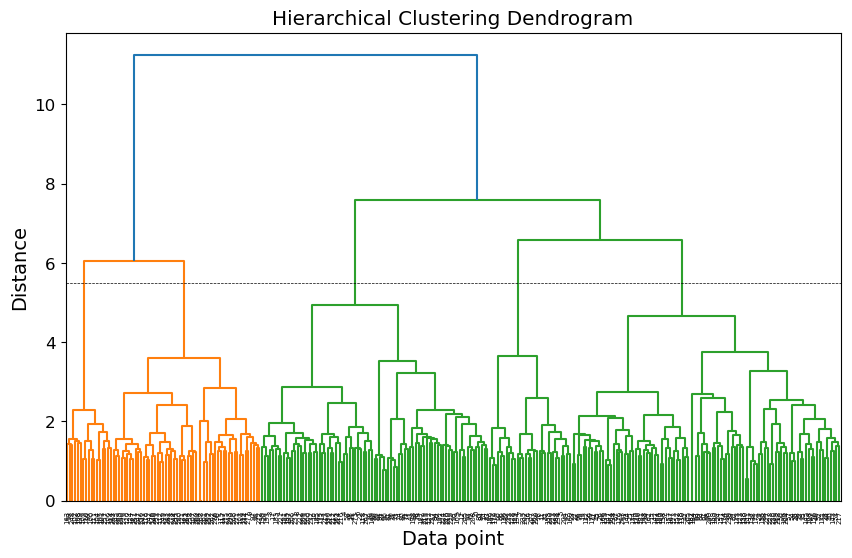

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage

# We use ward as the linkage method and we plot the dendrogram
Z = linkage(similarity_matrix, 'ward')
plt.figure(figsize=(10,6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)  
plt.axhline(y=5.5, c="k", ls="--", lw=0.5)
plt.show()

In [43]:
title = data['Title']
dfcleanC = pd.merge(title, dfclean, left_index=True, right_index=True)
dfcleanC

Title  \
0         WHO coronavirus disease (COVID-19) dashboard   
1    WHO. Coronavirus disease (COVID-19) advice for...   
2    COVID-19 patients and the radiology department...   
3    An update on COVID-19 for the radiologist-A Br...   
4    A British Society of Thoracic Imaging statemen...   
..                                                 ...   
277  D2A U-net: automatic segmentation of COVID-19 ...   
278  Diagnosing COVID-19 pneumonia from x-ray and C...   
279  Classification of COVID-19 chest X-Ray and CT ...   
280  FBSED based automatic diagnosis of COVID-19 us...   
281  Deep-chest: multi-classification deep learning...   

                                              abstract  
0    the global pandem caus diseas call coronaviru ...  
1    coronaviru diseas infecti diseas caus newli di...  
2    thi document european societi radiolog esr eur...  
3    in decemb citi hubei provinc report febril res...  
4    in accord guidanc chief medic offic offic roya...  
..                                                 ...  
277  coronaviru diseas becom one urgent public heal...  
278  the novel coronaviru first appear provinc spre...  
279  understand classifi chest x ray cxr computeris...  
280  thi work introduc fourier bessel seri expans b...  
281  viru diseas announc pandem spread rapidli thro...  

[282 rows x 2 columns]

In [44]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                         
                             stop_words='english',            
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,                
                             ngram_range=(1, 3)
                            )
data_vectorized = vectorizer.fit_transform(dfclean['abstract'])

In [45]:
from sklearn.cluster import KMeans
# the number of clusters comes from hierarchical clustering output
k = 5
km = KMeans(n_clusters=k, max_iter=10000, n_init=50, random_state=42).fit(data_vectorized)

In [46]:
# we add a column with cluster membership
dfcleanC['kmeans_cluster'] = km.labels_
clusters = (dfcleanC[['Title', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
clusters = clusters.copy(deep=True)

In [47]:
feature_names = vectorizer.get_feature_names_out()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
for cluster_num in range(k):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    title = clusters[ clusters['kmeans_cluster'] == cluster_num]['Title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('titles:', title)
    print('-'*80)

CLUSTER #1
Key Features: ['patient', 'day', 'studi', 'group', 'sever', 'dose', 'viral', 'treatment', 'therapi', 'data', 'receiv', 'test', 'iqr', 'gener', 'result']
titles: ['Clinical and CT imaging features of 2019 novel coronavirus disease (COVID-19)', 'Clinical and CT imaging features of 2019 novel coronavirus disease (COVID-19)']
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['patient', 'chest', 'pneumonia', 'case', 'clinic', 'imag', 'diseas', 'lesion', 'consolid', 'opac', 'lung', 'sever', 'glass', 'ground', 'ground glass']
titles: ['Clinical and CT features in pediatric patients with COVID‐19 infection: different points from adults', 'A characteristic chest radiographic pattern in the setting of COVID-19 pandemic', 'Epidemiological, clinical characteristics of cases of SARS-CoV-2 infection with abnormal imaging findings', 'Analysis of CT features of 15 children with 2019 novel coronavirus infection', 'A comparative study o

## Prediction of modalities and methods

##### Modalities
* CXR = Chest X Ray is a medical imaging procedure that uses X-rays to create an image of the inside of the chest.
* CT = Computed Tomography is a medical imaging technique that uses X-rays and computer processing to create detailed cross-sectional images of the body.

##### Methods
* CNN = Convolutional Neural Network is a type of deep learning algorithm that is primarily used for image recognition and processing tasks.
* BCNN = Binary Convolutional Neural Networks are a type of neural network where the weights and activations are binary values.
* AE = Autoencoder is a type of artificial neural network used for unsupervised learning. It aims to learn efficient data codings by training the network to copy its input to its output.
* GAN =  Generative Adversarial Network is a type of computer program that learns to create new data that looks very similar to existing data.

In [48]:
# take the training set
training_set = data.dropna()
training_set.head(10)

Title  \
112  Automatic detection of coronavirus disease (co...   
113  Covidx-net: A Framework of Deep Learning Class...   
114  Estimating Uncertainty and Interpretability in...   
115  A deep transfer learning model with classical ...   
116  Extracting possibly representative COVID-19 Bi...   
117  A Weakly-Supervised Framework for COVID-19 Cla...   
118  Weakly supervised deep learning for COVID-19 i...   
119  COVID-Net: a tailored deep convolutional neura...   
120  Deep learning COVID-19 features on CXR using l...   
241  Covid-19: automatic detection from x-ray image...   

                                              abstract modality    method  
112  The 2019 novel coronavirus disease (COVID-19),...      CXR       CNN  
113  Coronaviruses (CoV) are perilous viruses that ...      CXR       CNN  
114  Deep Learning has achieved state of the art pe...      CXR      BCNN  
115  The Coronavirus disease 2019 (COVID-19) is the...       CT  CNN CGAN  
116  While the spread of COVID-19 is increased, new...      CXR       CNN  
117  Accurate and rapid diagnosis of COVID-19 suspe...       CT       CNN  
118  An outbreak of a novel coronavirus disease (i....       CT       CNN  
119  The Coronavirus Disease 2019 (COVID-19) pandem...      CXR       CNN  
120  Under the global pandemic of COVID-19, the use...      CXR       CNN  
241  In this study, a dataset of X-ray images from ...      CXR       CNN

In [49]:
x_train = training_set["abstract"]
y_trainmod = training_set["modality"]
y_trainmet = training_set["method"]
x_train.shape

(50,)

In [50]:
test_set = data[data['modality'].isna()]
test_set

Title  \
0         WHO coronavirus disease (COVID-19) dashboard   
1    WHO. Coronavirus disease (COVID-19) advice for...   
2    COVID-19 patients and the radiology department...   
3    An update on COVID-19 for the radiologist-A Br...   
4    A British Society of Thoracic Imaging statemen...   
..                                                 ...   
236  CT imaging of the 2019 novel coronavirus (2019...   
237  Mobile X-rays are highly valuable for critical...   
238  Chest x-ray findings and temporal lung changes...   
239  Chest X-ray for predicting mortality and the n...   
240  Correlation of chest radiography findings with...   

                                              abstract modality method  
0    The 2019-2020 global pandemic has been caused ...      NaN    NaN  
1    Coronavirus disease (COVID-19) is an infectiou...      NaN    NaN  
2    This document from the European Society of Rad...      NaN    NaN  
3    In December 2019, Wuhan City (Hubei Province, ...      NaN    NaN  
4    In accordance with guidance from the Chief Med...      NaN    NaN  
..                                                 ...      ...    ...  
236  A 33-year-old woman presented to the hospital ...      NaN    NaN  
237  The diagnostic value of CT for SARS-CoV-2 infe...      NaN    NaN  
238  Chest CT scan and chest x-rays show characteri...      NaN    NaN  
239  To evaluate the inter-rater agreement of chest...      NaN    NaN  
240  Aim is to assess the temporal changes and prog...      NaN    NaN  

[232 rows x 4 columns]

In [51]:
x_test = test_set["abstract"]
x_test.shape

(232,)

In [52]:
# vectorization 
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [53]:
# classification with SVC model for modalities
from sklearn.svm import SVC
classifiermod = SVC() 
classifiermod.fit(x_train_tfidf, y_trainmod);

In [54]:
# classification with SVC model for methods
classifiermet = SVC()
classifiermet.fit(x_train_tfidf, y_trainmet);

In [55]:
# predictions 
predictionsmod = classifiermod.predict(x_test_tfidf)
predictionsmod

array(['CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CT', 'CXR', 'CXR', 'CXR', 'CXR', 'CT', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CT', 'CXR', 'CT', 'CXR', 'CXR',
       'CXR', 'CT', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR',
       'CXR', 'CT', 'CT', 'CXR', 'CXR', 'CXR', 'CXR', 'CXR', 'CT', 'CXR',
       

In [56]:
predictionsmet = classifiermet.predict(x_test_tfidf)
predictionsmet

array(['CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN',
       'CNN', 'CNN',

In [57]:
modality_pred = pd.DataFrame(predictionsmod)
modality_pred.rename(columns={0: "Predicted modalities"}, inplace=True)
datac = pd.concat([data,modality_pred], axis=1)

methods_pred = pd.DataFrame(predictionsmet)
methods_pred.rename(columns={0: "Predicted methods"}, inplace=True)
datamet = pd.concat([datac,methods_pred], axis=1)
datamet

Title  \
0         WHO coronavirus disease (COVID-19) dashboard   
1    WHO. Coronavirus disease (COVID-19) advice for...   
2    COVID-19 patients and the radiology department...   
3    An update on COVID-19 for the radiologist-A Br...   
4    A British Society of Thoracic Imaging statemen...   
..                                                 ...   
277  D2A U-net: automatic segmentation of COVID-19 ...   
278  Diagnosing COVID-19 pneumonia from x-ray and C...   
279  Classification of COVID-19 chest X-Ray and CT ...   
280  FBSED based automatic diagnosis of COVID-19 us...   
281  Deep-chest: multi-classification deep learning...   

                                              abstract modality method  \
0    The 2019-2020 global pandemic has been caused ...      NaN    NaN   
1    Coronavirus disease (COVID-19) is an infectiou...      NaN    NaN   
2    This document from the European Society of Rad...      NaN    NaN   
3    In December 2019, Wuhan City (Hubei Province, ...      NaN    NaN   
4    In accordance with guidance from the Chief Med...      NaN    NaN   
..                                                 ...      ...    ...   
277  Coronavirus Disease 2019 (COVID-19) has become...       CT    CNN   
278  The novel coronavirus 2019 (COVID-19) first ap...   CXR CT    CNN   
279  Understanding and classifying Chest X-Ray (CXR...   CXR CT    CNN   
280  This work introduces the Fourier-Bessel series...   CXR CT    CNN   
281  Corona Virus Disease (COVID-19) has been annou...      CXR    CNN   

    Predicted modalities Predicted methods  
0                    CXR               CNN  
1                    CXR               CNN  
2                    CXR               CNN  
3                    CXR               CNN  
4                    CXR               CNN  
..                   ...               ...  
277                  NaN               NaN  
278                  NaN               NaN  
279                  NaN               NaN  
280                  NaN               NaN  
281                  NaN               NaN  

[282 rows x 6 columns]

In [58]:
datamet.groupby(['Predicted modalities']).size().sort_values(ascending=False).reset_index(name='count')

Predicted modalities  count
0                  CXR    213
1                   CT     19

In [59]:
datamet.groupby(['modality']).size().sort_values(ascending=False).reset_index(name='count')

modality  count
0      CXR     30
1       CT     17
2   CXR CT      3

In [60]:
datamet.groupby(['Predicted methods']).size().sort_values(ascending=False).reset_index(name='count')

Predicted methods  count
0               CNN    232

In [61]:
datamet.groupby(['method']).size().sort_values(ascending=False).reset_index(name='count')

method  count
0       CNN     46
1        AE      1
2      BCNN      1
3  CNN CGAN      1
4   CNN GAN      1